# Q-Learning für Verzerrer-Parameteroptimierung

In diesem Jupyter-Notebook verwenden wir Q-Learning, um die optimalen Parameter für einen Verzerrer zu finden. Der Code ist in verschiedene Sektionen unterteilt:

**1. Einrichtung und Initialisierung**
- **Bibliotheken**: Import von notwendigen Bibliotheken wie `numpy` und `scipy`.

**2. DistortionParameters-Klasse**
- **Zweck**: Repräsentiert die Parameter des Verzerrers: `Gain`, `Tone` und `Level`.
- **Methoden**: Zum Setzen und Abrufen dieser Parameter.

**3. Environment-Klasse: Verzerrer und Signal**
- **Signal**: Generiert ein Sinussignal und verarbeitet es mit dem Verzerrer.
- **Verarbeitung**: Methoden wie `_apply_gain`, `_apply_tone` und `_apply_level`.

**4. Q-Learning-Agent-Klasse**
- **Algorithmus**: Implementiert den Q-Learning-Algorithmus.
- **Q-Tabelle**: Wird zum Lernen der besten Aktionen (Parameter) verwendet.
- **Methoden**: Zum Wählen von Aktionen und Aktualisieren der Q-Tabelle.

**5. Training**
- **Prozess**: Trainiert den Q-Learning-Agenten über mehrere Episoden.
- **Belohnung**: In jeder Episode wird das Signal verarbeitet und eine Belohnung basierend auf dem Unterschied zum Ziel-Ausgangssignal berechnet.

**6. Ergebnisse**
- **Ausgabe**: Zeigt die gelernten optimalen Parameter nach dem Training.


### **Sektion 1: Einrichtung und Initialisierung**

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import butter, lfilter
from numpy.fft import fft

# Addons
from sklearn.model_selection import KFold
import scipy
import random
from collections import deque

### **Sektion 2: DistortionParameters-Klasse**


In [2]:

class DistortionParameters:
    def __init__(self, gain=0.5, tone=0.5, level=0.5):
        self.gain = gain
        self.tone = tone
        self.level = level
    
    def set_parameters(self, gain, tone, level):
        self.gain = gain
        self.tone = tone
        self.level = level
        
    def get_parameters(self):
        return self.gain, self.tone, self.level

### **Sektion 3: Environment-Klasse: Verzerrer und Signal**

In [3]:
class DistortionEnvironment:
    def __init__(self, params):
        self.params = params
        self.signal = self._generate_signal()
        self.target_signal = self.process(self.signal)
    
    def _generate_signal(self):
        t = np.linspace(0, 1, 44100)
        return np.sin(2 * np.pi * 440 * t)
    
    def process(self, signal):
        return self._apply_level(self._apply_tone(self._apply_gain(signal, self.params.gain), self.params.tone), self.params.level)
    
    def _apply_gain(self, signal, gain):
        return np.clip(signal * gain, -1, 1)
    
    def _apply_tone(self, signal, tone):
        nyq = 0.5 * 44100
        low = 300
        high = 6000
        cutoff = low + (high - low) * tone
        b, a = butter(1, cutoff / nyq, btype='low')
        return lfilter(b, a, signal)
    
    def _apply_level(self, signal, level):
        return signal * level

### **4. Q-Learning-Agent-Klasse**

In [4]:
# ToDo: Parameter vll. mit CrossValidation? Bzw. Recherche was
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((11, 11, 11))
    
    def choose_action(self):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.rand(3)  # Random Action
        else:
            indices = np.unravel_index(np.argmax(self.q_table, axis=None), self.q_table.shape)  # Greedy Action
            return indices[0] / 10, indices[1] / 10, indices[2] / 10
    
    def update(self, state, next_state, reward):
        future_value = np.max(self.q_table[tuple((np.array(next_state) * 10).astype(int))])
        index = tuple((np.array(state) * 10).astype(int))
        self.q_table[index] = (
            self.q_table[index] + 
            self.alpha * (reward + self.gamma * future_value - self.q_table[index])
        )


### **Helper Functions**

In diesem Abschnitt werden Hilfsfunktionen definiert, die im weiteren Verlauf des Notebooks verwendet werden:

1. **`moving_average`**:
    - **Zweck**: Berechnet den gleitenden Durchschnitt einer gegebenen Datenreihe.
    - **Parameter**:
        - `values`: Die Datenreihe.
        - `window`: Die Größe des Fensters für den gleitenden Durchschnitt.
    - **Rückgabewert**: Eine Liste der gleitenden Durchschnittswerte.
</br></br>

2. **`compute_snr`**:
    - **Zweck**: Berechnet das Signal-Rausch-Verhältnis (SNR) zwischen einem Signal und einem Referenzsignal.
    - **Parameter**:
        - `signal`: Das zu bewertende Signal.
        - `reference`: Das Referenzsignal.
    - **Rückgabewert**: Das berechnete SNR.
</br></br>

3. **`reward_function`**:
    - **Zweck**: Berechnet die Belohnung basierend auf dem Unterschied zwischen dem Ausgangssignal und dem Ziel-Audiosignal. Die Funktion berücksichtigt sowohl den Fehler im Frequenzbereich als auch das SNR.
    - **Parameter**:
        - `output_signal`: Das Ausgangssignal des Verzerrers.
        - `target_signal`: Das Ziel-Audiosignal.
    - **Rückgabewert**: Ein Wert, der die Belohnung (oder den negativen Fehler) repräsentiert.
</br></br>


In [5]:
def moving_average(values, window):
    # Berechnet den gleitenden Durchschnitt
    return np.convolve(values, np.ones(window)/window, mode='valid')

def compute_snr(signal, reference):
    error = signal - reference
    signal_power = np.mean(signal**2)
    error_power = np.mean(error**2)
    
    # Überprüfen, ob der Fehler null ist
    if error_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / error_power)

def reward_function(output_signal, target_signal):
    # Transform both signals into the frequency domain
    output_freq = fft(output_signal)
    target_freq = fft(target_signal)
    
    # Calculate the error in the frequency domain
    freq_error = np.abs(output_freq - target_freq)
    
    # Weight the error by frequency (for simplicity, this example uses linear weighting)
    weighted_error = freq_error * np.linspace(1, 2, len(freq_error))
    
    # Compute the SNR
    snr = compute_snr(output_signal, target_signal)
    
    # Combine the weighted error and SNR (you can adjust the weighting factor)
    combined_error = np.mean(weighted_error) - 0.01 * snr
    
    # Überprüfen, ob der kombinierte Fehler gültig ist
    if np.isnan(combined_error) or np.isinf(combined_error):
        return -np.mean(weighted_error)  # Verwenden Sie nur den gewichteten Fehler als Belohnung
    
    return -combined_error



### **Sektion 5: Training**

Randomized:
gain : 0.8
tone : 0.3
level : 0.7
Episode 100/1000, Average Reward (last 100 episodes): -1.060


/tmp/ipykernel_24600/1307526012.py:13: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(signal_power / error_power)


Episode 200/1000, Average Reward (last 100 episodes): -1.037
Episode 300/1000, Average Reward (last 100 episodes): -1.090
Episode 400/1000, Average Reward (last 100 episodes): -1.107
Episode 500/1000, Average Reward (last 100 episodes): -1.086
Episode 600/1000, Average Reward (last 100 episodes): -0.986
Episode 700/1000, Average Reward (last 100 episodes): -1.001
Episode 800/1000, Average Reward (last 100 episodes): -0.961
Episode 900/1000, Average Reward (last 100 episodes): -0.851
Episode 1000/1000, Average Reward (last 100 episodes): -0.916


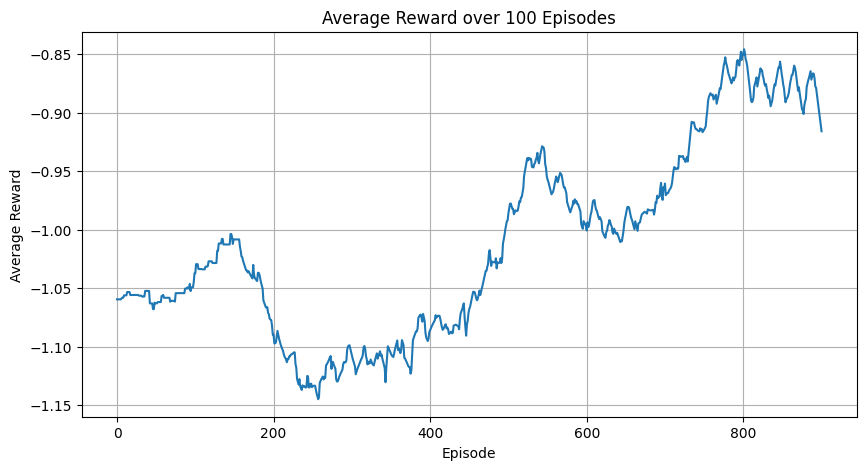

In [6]:
params = DistortionParameters(round(np.random.rand(), 1), round(np.random.rand(), 1), round(np.random.rand(), 1))
env = DistortionEnvironment(params)
agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.2)
rewards = []
epochs = 1000

# Print random gains
print("Randomized:")
for key, value in vars(params).items():
    print(key, ":", value)

print_interval = 100  # Status alle 100 Episoden drucken

# Stoppkriterium
convergence_threshold = 0.01  # Minimale Änderung der durchschnittlichen Belohnung
convergence_window = 5000  # Anzahl der Episoden, über die die Konvergenz überprüft wird

# Prozess
for episode in range(epochs):
    current_state = [params.gain, params.tone, params.level]
    action = agent.choose_action()
    params.set_parameters(*action)
    output_signal = env.process(env.signal)
    reward = reward_function(output_signal, env.target_signal)
    rewards.append(reward)
    next_state = [params.gain, params.tone, params.level]  # Nachdem die Aktion angewendet wurde
    agent.update(current_state, next_state, reward)
    
    # Status drucken
    if (episode + 1) % print_interval == 0:
        avg_reward_last_n = np.mean(rewards[-print_interval:])
        print(f"Episode {episode + 1}/{epochs}, Average Reward (last {print_interval} episodes): {avg_reward_last_n:.3f}")

    # Überprüfen Sie die Konvergenz alle 'convergence_window' Episoden
    if (episode + 1) % convergence_window == 0:
        avg_reward_last_n = np.mean(rewards[-convergence_window:])
        avg_reward_prev_n = np.mean(rewards[-2*convergence_window:-convergence_window])
        
        if abs(avg_reward_last_n - avg_reward_prev_n) < convergence_threshold:
            print(f"Convergence achieved at episode {episode + 1}. Stopping training.")
            break

# Plot
window_size = 100
avg_rewards = moving_average(rewards, window_size)

plt.figure(figsize=(10,5))
plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title(f'Average Reward over {window_size} Episodes')
plt.grid(True)
plt.show()


### **Sektion 6: Ergebnisse**

In [7]:
optimal_indices = np.unravel_index(np.argmax(agent.q_table, axis=None), agent.q_table.shape)
optimal_params = DistortionParameters(optimal_indices[0] / 10, optimal_indices[1] / 10, optimal_indices[2] / 10)

print("Echte Parameter - Gain:", params.gain, "Tone:", params.tone, "Level:", params.level)
print("Gelernte Parameter - Gain:", optimal_params.gain, "Tone:", optimal_params.tone, "Level:", optimal_params.level)


Echte Parameter - Gain: 0.4 Tone: 0.0 Level: 0.4
Gelernte Parameter - Gain: 0.4 Tone: 0.0 Level: 0.4
